In [1]:
from dataclasses import dataclass
from typing import Any, Optional, Tuple

import torch
import torch.nn.functional as F
from torch import nn

import pandas as pd
import random
import math
import os

from torch.utils.tensorboard import SummaryWriter

from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler

import matplotlib.pyplot as plt

C:\Users\arshs\AppData\Local\Temp\ipykernel_19824\4204762261.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
writer = SummaryWriter("runs/socllama_tl")
# tensorboard --logdir runs

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
req_parameters = [
                  'Velocity [km/h]', 'Throttle [%]', 'Motor Torque [Nm]', 'Regenerative Braking Signal ', 'Battery Voltage [V]', 
                  'Battery Current [A]','SoC [%]'
                 ]

In [5]:
dataclass
class ModelArgs:
    dim: int = 256
    n_layers: int = 2
    n_heads: int = 8
    n_kv_heads: Optional[int] = None
    #vocab_size: int = 32000
    n_features : int = len(req_parameters)
    hidden_dim: Optional[int] = None
    multiple_of: int = 256  # MLP hidden layer size will be multiple of
    norm_eps: float = 1e-5
    max_seq_len: int = 300
    dropout: float = 0.2

    max_batch_size : int = 5
    lr : float = 0.01
    epochs : int = 1000
    split_ratio : float = 0.8

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim)).to(device)

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight


def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim)).to(device)
    t = torch.arange(end, device=freqs.device).to(device)  # type: ignore
    freqs = torch.outer(t, freqs).float().to(device)  # type: ignore
    freqs_cos = torch.cos(freqs).to(device)  # real part
    freqs_sin = torch.sin(freqs).to(device)  # imaginary part
    return freqs_cos, freqs_sin

def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    ndim = x.ndim
    assert 0 <= 1 < ndim
    assert freqs_cis.shape == (x.shape[1], x.shape[-1])
    shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in enumerate(x.shape)]
    return freqs_cis.view(shape)

def apply_rotary_emb(xq: torch.Tensor, xk: torch.Tensor, freqs_cos: torch.Tensor, freqs_sin: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    # reshape xq and xk to match the complex representation
    xq_r, xq_i = xq.float().reshape(xq.shape[:-1] + (-1, 2)).unbind(-1)
    xk_r, xk_i = xk.float().reshape(xk.shape[:-1] + (-1, 2)).unbind(-1)

    # reshape freqs_cos and freqs_sin for broadcasting
    freqs_cos = reshape_for_broadcast(freqs_cos, xq_r)
    freqs_sin = reshape_for_broadcast(freqs_sin, xq_r)

    # apply rotation using real numbers
    xq_out_r = xq_r * freqs_cos - xq_i * freqs_sin
    xq_out_i = xq_r * freqs_sin + xq_i * freqs_cos
    xk_out_r = xk_r * freqs_cos - xk_i * freqs_sin
    xk_out_i = xk_r * freqs_sin + xk_i * freqs_cos

    # flatten last two dimensions
    xq_out = torch.stack([xq_out_r, xq_out_i], dim=-1).flatten(3)
    xk_out = torch.stack([xk_out_r, xk_out_i], dim=-1).flatten(3)

    return xq_out.type_as(xq), xk_out.type_as(xk)

def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    """torch.repeat_interleave(x, dim=2, repeats=n_rep)"""
    bs, slen, n_kv_heads, head_dim = x.shape
    if n_rep == 1:
        return x
    return (
        x[:, :, :, None, :]
        .expand(bs, slen, n_kv_heads, n_rep, head_dim)
        .reshape(bs, slen, n_kv_heads * n_rep, head_dim)
    )

class Attention(nn.Module):
    def __init__(self, args: ModelArgs):
        super().__init__()
        self.n_kv_heads = args.n_heads if args.n_kv_heads is None else args.n_kv_heads
        assert args.n_heads % self.n_kv_heads == 0
        model_parallel_size = 1
        self.n_local_heads = args.n_heads // model_parallel_size
        self.n_local_kv_heads = self.n_kv_heads // model_parallel_size
        self.n_rep = self.n_local_heads // self.n_local_kv_heads
        self.head_dim = args.dim // args.n_heads
        self.wq = nn.Linear(args.dim, args.n_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(args.dim, self.n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(args.dim, self.n_kv_heads * self.head_dim, bias=False)
        self.wo = nn.Linear(args.n_heads * self.head_dim, args.dim, bias=False)
        self.attn_dropout = nn.Dropout(args.dropout)
        self.resid_dropout = nn.Dropout(args.dropout)
        self.dropout = args.dropout

        # use flash attention or a manual implementation?
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            mask = torch.full((1, 1, args.max_seq_len, args.max_seq_len), float("-inf"))
            mask = torch.triu(mask, diagonal=1)
            self.register_buffer("mask", mask)

    def forward(self, x: torch.Tensor, freqs_cos: torch.Tensor, freqs_sin: torch.Tensor,):
        bsz, seqlen, _ = x.shape

        # QKV
        xq, xk, xv = self.wq(x), self.wk(x), self.wv(x)
        xq = xq.view(bsz, seqlen, self.n_local_heads, self.head_dim)
        xk = xk.view(bsz, seqlen, self.n_local_kv_heads, self.head_dim)
        xv = xv.view(bsz, seqlen, self.n_local_kv_heads, self.head_dim)

        # RoPE relative positional embeddings
        xq, xk = apply_rotary_emb(xq, xk, freqs_cos, freqs_sin)

        # grouped multiquery attention: expand out keys and values
        xk = repeat_kv(xk, self.n_rep)  # (bs, seqlen, n_local_heads, head_dim)
        xv = repeat_kv(xv, self.n_rep)  # (bs, seqlen, n_local_heads, head_dim)

        # make heads into a batch dimension
        xq = xq.transpose(1, 2)  # (bs, n_local_heads, seqlen, head_dim)
        xk = xk.transpose(1, 2)
        xv = xv.transpose(1, 2)

        # flash implementation
        if self.flash:
            output = torch.nn.functional.scaled_dot_product_attention(xq, xk, xv, attn_mask=None, dropout_p=self.dropout if self.training else 0.0, is_causal=True)
        else:
            # manual implementation
            scores = torch.matmul(xq, xk.transpose(2, 3)) / math.sqrt(self.head_dim)
            assert hasattr(self, 'mask')
            scores = scores + self.mask[:, :, :seqlen, :seqlen]   # (bs, n_local_heads, seqlen, cache_len + seqlen)
            scores = F.softmax(scores.float(), dim=-1).type_as(xq)
            scores = self.attn_dropout(scores)
            output = torch.matmul(scores, xv)  # (bs, n_local_heads, seqlen, head_dim)

        # restore time as batch dimension and concat heads
        output = output.transpose(1, 2).contiguous().view(bsz, seqlen, -1)

        # final projection into the residual stream
        output = self.wo(output)
        output = self.resid_dropout(output)
        return output

class FeedForward(nn.Module):
    def __init__(self, dim: int, hidden_dim: int, multiple_of: int, dropout: float):
        super().__init__()
        if hidden_dim is None:
            hidden_dim = 4 * dim
            hidden_dim = int(2 * hidden_dim / 3)
            hidden_dim = multiple_of * ((hidden_dim + multiple_of - 1) // multiple_of)
        self.w1 = nn.Linear(dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, dim, bias=False)
        self.w3 = nn.Linear(dim, hidden_dim, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(self.w2(F.silu(self.w1(x)) * self.w3(x)))


class TransformerBlock(nn.Module):
    def __init__(self, layer_id: int, args: ModelArgs):
        super().__init__()
        self.n_heads = args.n_heads
        self.dim = args.dim
        self.head_dim = args.dim // args.n_heads
        self.attention = Attention(args)
        self.feed_forward = FeedForward(
            dim=args.dim,
            hidden_dim=args.hidden_dim,
            multiple_of=args.multiple_of,
            dropout=args.dropout,
        )
        self.layer_id = layer_id
        self.attention_norm = RMSNorm(args.dim, eps=args.norm_eps)
        self.ffn_norm = RMSNorm(args.dim, eps=args.norm_eps)

    def forward(self, x, freqs_cos, freqs_sin):
        h = x + self.attention.forward(self.attention_norm(x), freqs_cos, freqs_sin)
        out = h + self.feed_forward.forward(self.ffn_norm(h))
        return out


class Transformer(nn.Module):
    last_loss: Optional[torch.Tensor]

    def __init__(self, params: ModelArgs):
        super().__init__()
        self.params = params
        # self.vocab_size = params.vocab_size
        self.n_layers = params.n_layers

        # self.tok_embeddings = nn.Embedding(params.vocab_size, params.dim)
        self.tok_embeddings = nn.Linear(params.n_features, params.dim, bias=False)

        self.dropout = nn.Dropout(params.dropout)
        self.layers = torch.nn.ModuleList()
        for layer_id in range(params.n_layers):
            self.layers.append(TransformerBlock(layer_id, params))
        self.norm = RMSNorm(params.dim, eps=params.norm_eps)

        #self.output = nn.Linear(params.dim, params.vocab_size, bias=False)
        self.output = nn.Linear(params.dim, 1, bias = False)

        # share the unembedding parameters with the embedding parameters
        #self.tok_embeddings.weight = self.output.weight # https://paperswithcode.com/method/weight-tying

        # some useful precompute for the RoPE relative positional embeddings
        freqs_cos, freqs_sin = precompute_freqs_cis(self.params.dim // self.params.n_heads, self.params.max_seq_len)
        self.register_buffer("freqs_cos", freqs_cos, persistent=False)
        self.register_buffer("freqs_sin", freqs_sin, persistent=False)

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('w3.weight') or pn.endswith('wo.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * params.n_layers))

        # Initialize attribute for the loss of the last forward call. This will be set if the forward is called with a targets tensor.
        self.last_loss = None

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, tokens: torch.Tensor, targets: Optional[torch.Tensor] = None) -> torch.Tensor:
        _bsz, seqlen, n_features = tokens.shape
        h = self.tok_embeddings(tokens)
        h = self.dropout(h)
        freqs_cos = self.freqs_cos[:seqlen]
        freqs_sin = self.freqs_sin[:seqlen]

        for layer in self.layers:
            h = layer(h, freqs_cos, freqs_sin)
        h = self.norm(h)
        h = h[:, -1, :]
        logits = self.output(h)

        # if targets is not None:
        #     # if we are given some desired targets also calculate the loss
        #     logits = self.output(h)
        #     self.last_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        # else:
        #     # inference-time mini-optimization: only forward the output on the very last position
        #     logits = self.output(h[:, [-1], :]) # note: using list [-1] to preserve the time dim
        #     self.last_loss = None

        return torch.squeeze(logits)

    # def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
    #     # start with all of the candidate parameters
    #     param_dict = {pn: p for pn, p in self.named_parameters()}
    #     # filter out those that do not require grad
    #     param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
    #     # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
    #     # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
    #     decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
    #     nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
    #     optim_groups = [
    #         {'params': decay_params, 'weight_decay': weight_decay},
    #         {'params': nodecay_params, 'weight_decay': 0.0}
    #     ]
    #     num_decay_params = sum(p.numel() for p in decay_params)
    #     num_nodecay_params = sum(p.numel() for p in nodecay_params)
    #     print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
    #     print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
    #     # Create AdamW optimizer and use the fused version if it is available
    #     fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
    #     use_fused = fused_available and device_type == 'cuda'
    #     extra_args = dict(fused=True) if use_fused else dict()
    #     optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
    #     print(f"using fused AdamW: {use_fused}")

    #     return optimizer

    # def estimate_mfu(self, fwdbwd_per_iter, dt):
    #     """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
    #     # first estimate the number of flops we do per iteration.
    #     # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
    #     N = sum(p.numel() for p in self.parameters())
    #     cfg = self.params
    #     L, H, Q, T = cfg.n_layers, cfg.n_heads, cfg.dim//cfg.n_heads, cfg.max_seq_len
    #     flops_per_token = 6*N + 12*L*H*Q*T
    #     flops_per_fwdbwd = flops_per_token * T
    #     flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
    #     # express our flops throughput as ratio of A100 bfloat16 peak flops
    #     flops_achieved = flops_per_iter * (1.0/dt) # per second
    #     flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
    #     mfu = flops_achieved / flops_promised
    #     return mfu

    # @torch.inference_mode()
    # def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
    #     """
    #     Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
    #     the sequence max_new_tokens times, feeding the predictions back into the model each time.
    #     Most likely you'll want to make sure to be in model.eval() mode of operation for this.
    #     Also note this is a super inefficient version of sampling with no key/value cache.
    #     """
    #     for _ in range(max_new_tokens):
    #         # if the sequence context is growing too long we must crop it at block_size
    #         idx_cond = idx if idx.size(1) <= self.params.max_seq_len else idx[:, -self.params.max_seq_len:]
    #         # forward the model to get the logits for the index in the sequence
    #         logits = self(idx_cond)
    #         logits = logits[:, -1, :] # crop to just the final time step
    #         if temperature == 0.0:
    #             # "sample" the single most likely index
    #             _, idx_next = torch.topk(logits, k=1, dim=-1)
    #         else:
    #             # pluck the logits at the final step and scale by desired temperature
    #             logits = logits / temperature
    #             # optionally crop the logits to only the top k options
    #             if top_k is not None:
    #                 v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
    #                 logits[logits < v[:, [-1]]] = -float('Inf')
    #             # apply softmax to convert logits to (normalized) probabilities
    #             probs = F.softmax(logits, dim=-1)
    #             idx_next = torch.multinomial(probs, num_samples=1)
    #         # append sampled index to the running sequence and continue
    #         idx = torch.cat((idx, idx_next), dim=1)

    #     return idx

In [7]:
params = ModelArgs

In [10]:
def generate_dataset(path_location):

    input_batches = []
    output_batches = []

    all_files = os.listdir(path_location)
    file_paths = [os.path.join(path_location, file) for file in all_files]

    for file in file_paths :
        df = pd.read_csv(file, delimiter=';', encoding='ISO-8859-1')
        df = df[req_parameters]
        df['SoC [%]'] = df['SoC [%]'].shift(1)
        df = df.rename(columns={'SoC [%]' : 'prevsoc'})
        df.dropna(inplace=True)

        print(f'Successfully loaded file : {file}')

        input_tensors = []
        output_tensors = []
        start_index = 0
        for index, row in df.iterrows():
            if index == (len(df) - 1):
                break
            if (index + 1) % params.max_seq_len == 0:
                input_tensor = torch.tensor(df.iloc[start_index : index + 1].values, dtype=torch.float32).to(device)
                output_tensor = torch.tensor(df.iloc[index+1, df.columns.get_loc('prevsoc')], dtype=torch.float32).to(device)

                input_tensors.append(input_tensor)
                output_tensors.append(output_tensor)

                start_index = index + 1

        combined = list(zip(input_tensors, output_tensors))
        random.shuffle(combined)
        input_tensors, output_tensors = zip(*combined)

        temp_input_batches = []
        temp_output_batches = []

        for i in range(0, len(input_tensors), params.max_batch_size):
            input_batch =  torch.stack(input_tensors[i:i+params.max_batch_size])
            temp_input_batches.append(input_batch)

            output_batch =  torch.stack(output_tensors[i:i+params.max_batch_size])
            temp_output_batches.append(output_batch)

        temp_input_batches = temp_input_batches[:-1]
        temp_output_batches = temp_output_batches[:-1]

        input_batches += temp_input_batches
        output_batches += temp_output_batches

    n = len(input_batches)
    split_index = int(params.split_ratio * n)

    input_train_list = input_batches[:split_index]
    input_val_list = input_batches[split_index:]

    output_train_list = output_batches[:split_index]
    output_val_list = output_batches[split_index:]

    return input_train_list, input_val_list, output_train_list, output_val_list

path_location = 'winter_dataset'
input_train_list, input_val_list, output_train_list, output_val_list = generate_dataset(path_location)

train_data = len(input_train_list)
val_data = len(input_val_list)

print(f'Size of training data : {train_data}')
print(f'Size of validation data : {val_data}')

Successfully loaded file : winter_dataset\TripB01.csv
Successfully loaded file : winter_dataset\TripB02.csv
Successfully loaded file : winter_dataset\TripB03.csv
Successfully loaded file : winter_dataset\TripB04.csv
Successfully loaded file : winter_dataset\TripB05.csv
Successfully loaded file : winter_dataset\TripB06.csv
Successfully loaded file : winter_dataset\TripB07.csv
Successfully loaded file : winter_dataset\TripB08.csv
Successfully loaded file : winter_dataset\TripB09.csv
Successfully loaded file : winter_dataset\TripB10.csv
Successfully loaded file : winter_dataset\TripB11.csv
Successfully loaded file : winter_dataset\TripB12.csv
Successfully loaded file : winter_dataset\TripB13.csv
Successfully loaded file : winter_dataset\TripB14.csv
Successfully loaded file : winter_dataset\TripB15.csv
Successfully loaded file : winter_dataset\TripB16.csv
Successfully loaded file : winter_dataset\TripB17.csv
Successfully loaded file : winter_dataset\TripB18.csv
Successfully loaded file : w

In [11]:
FILE = "model2.pth"

model = Transformer(params)
model.load_state_dict(torch.load(FILE))
model.to(device)

print(count_parameters(model))

1705984


In [12]:
class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_t, y_prime_t):
        ey_t = y_t - y_prime_t
        return torch.mean(torch.log(torch.cosh(ey_t + 1e-12)))

# warmup_steps = 500
class Scheduler(_LRScheduler):
    def __init__(self, optimizer: Optimizer, dim_embed: int, warmup_steps: int, last_epoch: int=-1, verbose: bool=False) -> None:
        self.dim_embed = dim_embed
        self.warmup_steps = warmup_steps
        self.num_param_groups = len(optimizer.param_groups)

        super().__init__(optimizer, last_epoch, verbose)
        
    def get_lr(self) -> float:
        lr = calc_lr(self._step_count, self.dim_embed, self.warmup_steps)
        return [lr] * self.num_param_groups

def calc_lr(step, dim_embed, warmup_steps):
    return dim_embed**(-0.5) * min(step**(-0.5), step * warmup_steps**(-1.5))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1.0e-9)
scheduler = Scheduler(optimizer, params.dim, warmup_steps=20)

In [13]:
training_loss = []
validation_loss = []
learning_rate = []

print_steps = 100

for i in range(params.epochs):
    train_loss = 0
    for j in range(len(input_train_list)):
        input_batch = input_train_list[j]
        output_batch = output_train_list[j]

        optimizer.zero_grad()
        calculated_output = model(input_batch)

        loss = criterion(output_batch, calculated_output)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    val_loss = 0

    scheduler.step()

    with torch.no_grad():
        for j in range(len(input_val_list)):
            input_batch = input_val_list[j]
            output_batch = output_val_list[j]

            calculated_output = model(input_batch)

            loss = criterion(output_batch, calculated_output)
            val_loss += loss.item()

    temp_training_loss = train_loss / train_data
    temp_validation_loss = val_loss / val_data
    current_lr = optimizer.param_groups[0]['lr']

    writer.add_scalar('Training loss', temp_training_loss)
    writer.add_scalar('Validation Loss', temp_validation_loss)
    writer.add_scalar('Learning Rate', current_lr)

    print(f'epoch : {i+1}, Training loss : {temp_training_loss:.3f}, Validation loss : {temp_validation_loss:.3f}, Learning rate : {current_lr:.3f}')
    
    training_loss.append(temp_training_loss)
    validation_loss.append(temp_validation_loss)
    learning_rate.append(current_lr)

epoch : 1, Training loss : 1.373, Validation loss : 5.049, Learning rate : 0.001
epoch : 2, Training loss : 1.022, Validation loss : 3.150, Learning rate : 0.002
epoch : 3, Training loss : 1.033, Validation loss : 2.096, Learning rate : 0.003
epoch : 4, Training loss : 0.971, Validation loss : 1.684, Learning rate : 0.003
epoch : 5, Training loss : 1.035, Validation loss : 2.065, Learning rate : 0.004
epoch : 6, Training loss : 1.084, Validation loss : 10.239, Learning rate : 0.005
epoch : 7, Training loss : 1.477, Validation loss : 4.411, Learning rate : 0.006
epoch : 8, Training loss : 1.282, Validation loss : 4.652, Learning rate : 0.006
epoch : 9, Training loss : 1.651, Validation loss : 10.240, Learning rate : 0.007
epoch : 10, Training loss : 2.799, Validation loss : 2.552, Learning rate : 0.008
epoch : 11, Training loss : 1.659, Validation loss : 5.880, Learning rate : 0.008
epoch : 12, Training loss : 2.572, Validation loss : 3.079, Learning rate : 0.009
epoch : 13, Training lo

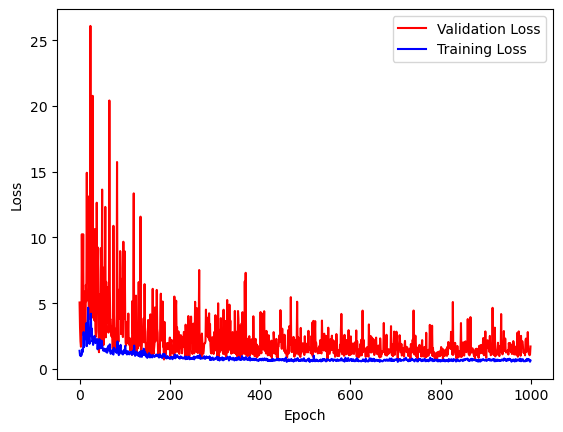

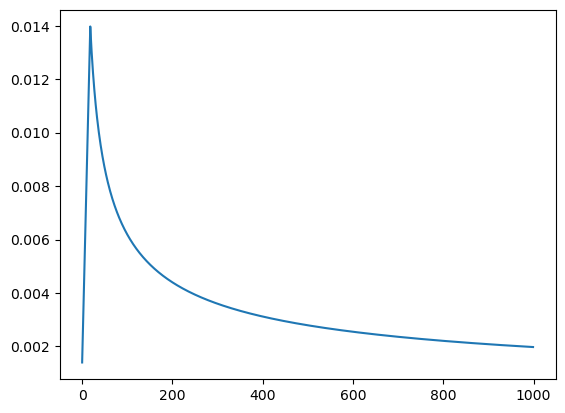

In [15]:
plt.plot(validation_loss, color='red', label='Validation Loss')
plt.plot(training_loss, color='blue', label='Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(learning_rate)
plt.show()

In [16]:
FILE = "model2_tl.pth"
torch.save(model.state_dict(), FILE)

In [22]:
dataclass
class ModelArgsTest:
    dim: int = 256
    n_layers: int = 2
    n_heads: int = 8
    n_kv_heads: Optional[int] = None
    #vocab_size: int = 32000
    n_features : int = len(req_parameters)
    hidden_dim: Optional[int] = None
    multiple_of: int = 256  # MLP hidden layer size will be multiple of
    norm_eps: float = 1e-5
    max_seq_len: int = 300
    dropout: float = 0.2

    max_batch_size : int = 1

params = ModelArgsTest

In [20]:
def generate_final_test_dataset(path_location):

    input_batches = []
    output_batches = []

    all_files = os.listdir(path_location)
    file_paths = [os.path.join(path_location, file) for file in all_files]

    for file in file_paths :
        df = pd.read_csv(file, delimiter=';', encoding='ISO-8859-1')
        df = df[req_parameters]
        df['SoC [%]'] = df['SoC [%]'].shift(1)
        df = df.rename(columns={'SoC [%]' : 'prevsoc'})
        df.dropna(inplace=True)

        input_tensors = []
        output_tensors = []
        start_index = 0
        for index, row in df.iterrows():
            if index == (len(df) - 1):
                break
            if (index + 1) % params.max_seq_len == 0:
                input_tensor = torch.tensor(df.iloc[start_index : index + 1].values, dtype=torch.float32).to(device)
                output_tensor = torch.tensor(df.iloc[index+1, df.columns.get_loc('prevsoc')], dtype=torch.float32).to(device)

                input_tensors.append(input_tensor)
                output_tensors.append(output_tensor)

                start_index = index + 1

        temp_input_batches = []
        temp_output_batches = []

        for i in range(0, len(input_tensors), params.max_batch_size):
            input_batch =  torch.stack(input_tensors[i:i+params.max_batch_size])
            temp_input_batches.append(input_batch)

            output_batch =  torch.stack(output_tensors[i:i+params.max_batch_size])
            temp_output_batches.append(output_batch)

        temp_input_batches = temp_input_batches[:-1]
        temp_output_batches = temp_output_batches[:-1]

        input_batches += temp_input_batches
        output_batches += temp_output_batches

    return input_batches, output_batches

path_location = 'winter_dataset'
input_batches, output_batches = generate_final_test_dataset(path_location)

print(f'Size of dataset : {len(input_batches)}')

Size of dataset : 1930


In [24]:
criterion = nn.MSELoss()

output = []
original_output = []

total_loss = 0
count = 0

with torch.no_grad():
    for i in range(len(input_batches)):

        calc_output = model(input_batches[i])
        output.append(calc_output.item())

        correct_output = output_batches[i]
        original_output.append(correct_output.item())
        
        loss = criterion(calc_output, correct_output)
        total_loss += loss.item()
        count += 1

print(f'Total MSE loss : {total_loss / count}')

Total MSE loss : 1.0253568899972634


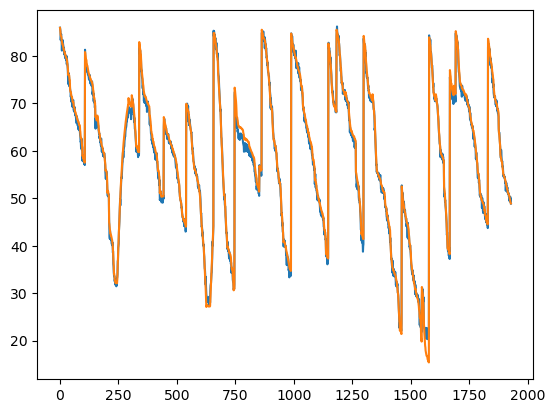

In [25]:
plt.plot(output)
plt.plot(original_output)

plt.show()